# Exercise 7.1

CIFAR-10 is a famous data set for the development of image recognition methods. It consists of small 32x32 pixel 8-bit RGB images of 10 different categories. Ten random images from each category are shown below. 

<img src="CIFAR-10-image.png" alt="drawing" width="400"/>

In this exercise, you will develop a neural network capable of classifying the images.

1\. Get familiar with the data structure, plot a few examples, and normalize the images.\
2\. Implement a fully connected network with two hidden layers of 256 nodes each, and a dropout layer between them. Train the network for at least 20 epochs.\
3\. Perform the classification using a convolutional network.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [ ]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [ ]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

170498071/170498071 [==============================] - 3s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

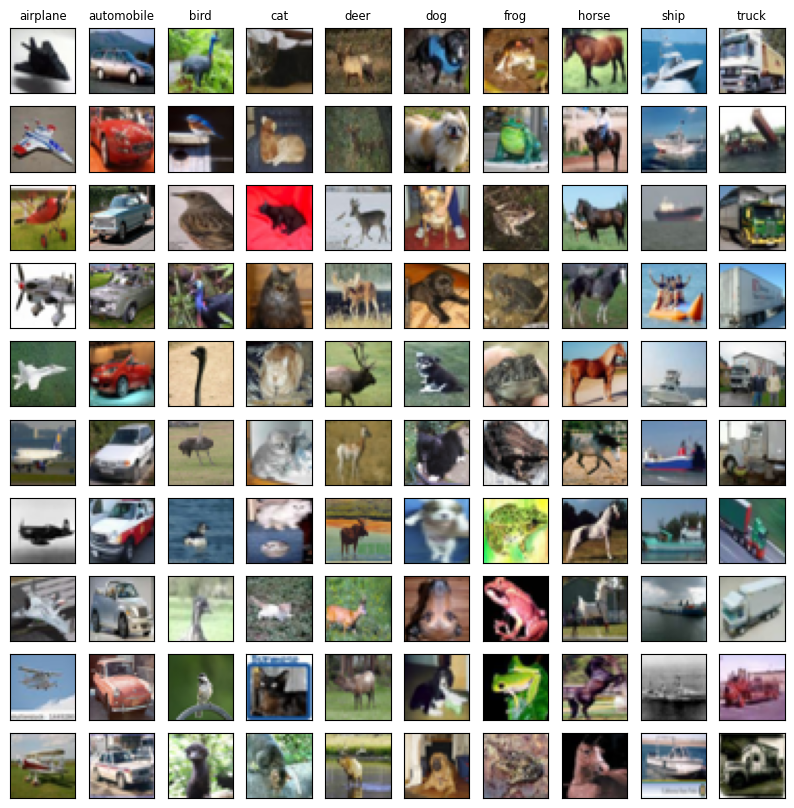

In [ ]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [ ]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
# Hint: use 20% of the training data for validation

# Normalize the data
x_train_normalized = x_train / 255
x_test_normalized = x_test / 255

# Split the training data into training and validation sets (80% training, 20% validation)
split_index = int(0.8 * len(x_train_normalized))
x_train_split, x_valid_split = x_train_normalized[:split_index], x_train_normalized[split_index:]
y_train_split, y_valid_split = y_train_onehot[:split_index], y_train_onehot[split_index:]

# Print shapes of the datasets
print("Training images, shape =", x_train_split.shape)
print("Training labels, shape =", y_train_split.shape)
print("Validation images, shape =", x_valid_split.shape)
print("Validation labels, shape =", y_valid_split.shape)

# Hint: To plot example images, you can use the plot examples function
# plot_examples(x_train_split, y_train_split)


Training images, shape = (40000, 32, 32, 3)
Training labels, shape = (40000, 10)
Validation images, shape = (10000, 32, 32, 3)
Validation labels, shape = (10000, 10)


We start with a fully connected network

In [ ]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------

model = tf.keras.models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        layers.Dense(256, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax")  # Output layer with 10 nodes and softmax activation
    ],
    name="nn",
)
"""
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        # this time the flatten operation is directly integrated into the network
        # structure so that we can use the same input data later for a convolutional neural network.
        ...
        # Hint: remember that the output layer should have 10 nodes with a softmax activation
    ],
    name="nn",
)
"""
print(model.summary())

Model: "nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               786688    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
Total params: 855050 (3.26 MB)
Trainable params: 855050 (3.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Since it's a multi-class classification problem
    metrics=['accuracy']
)

# Set the batch size and other parameters as needed
batch_size = 64

# Train the model
history = model.fit(
    x_train_split, y_train_split,
    batch_size=batch_size,
    epochs=20,
    verbose=2,
    validation_data=(x_valid_split, y_valid_split),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))]
)


Epoch 1/20
625/625 - 13s - loss: 1.8827 - accuracy: 0.3191 - val_loss: 1.7388 - val_accuracy: 0.3690 - 13s/epoch - 21ms/step
Epoch 2/20
625/625 - 10s - loss: 1.6965 - accuracy: 0.3903 - val_loss: 1.7012 - val_accuracy: 0.3880 - 10s/epoch - 16ms/step
Epoch 3/20
625/625 - 10s - loss: 1.6157 - accuracy: 0.4194 - val_loss: 1.6080 - val_accuracy: 0.4248 - 10s/epoch - 16ms/step
Epoch 4/20
625/625 - 9s - loss: 1.5572 - accuracy: 0.4425 - val_loss: 1.6132 - val_accuracy: 0.4309 - 9s/epoch - 14ms/step
Epoch 5/20
625/625 - 10s - loss: 1.5097 - accuracy: 0.4602 - val_loss: 1.5897 - val_accuracy: 0.4374 - 10s/epoch - 16ms/step
Epoch 6/20
625/625 - 9s - loss: 1.4823 - accuracy: 0.4696 - val_loss: 1.5504 - val_accuracy: 0.4525 - 9s/epoch - 15ms/step
Epoch 7/20
625/625 - 8s - loss: 1.4476 - accuracy: 0.4832 - val_loss: 1.4952 - val_accuracy: 0.4758 - 8s/epoch - 13ms/step
Epoch 8/20
625/625 - 9s - loss: 1.4280 - accuracy: 0.4878 - val_loss: 1.5103 - val_accuracy: 0.4684 - 9s/epoch - 15ms/step
Epoch 9/

'\nmodel.compile(\n    ...\n)\n\nmodel.fit(\n    ...\n    batch_size=...,\n    epochs=20, # train at least for 20 epochs\n    verbose=2,\n    validation_data=(x_valid_norm, y_valid_onehot),\n    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],\n)\n'

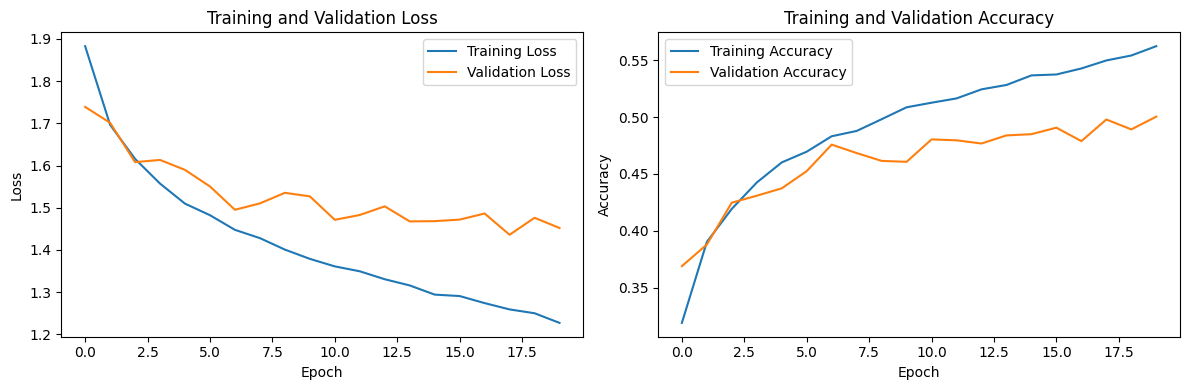

79/79 [==============================] - 1s 10ms/step
 len(y_predict_cl) = 8000
 len(y_test_cl) = 8000


'\n# training curves\nhistory = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)\n\n\n# Hint: this is how you can plot the confusion matrix.\n# calculate predictions for test set\ny_predict = model.predict(..., batch_size=128)\n\n# convert back to class labels (0-9)\ny_predict_cl = np.argmax(y_predict, axis=1)\ny_test_cl = np.argmax(y_test_onehot, axis=1)\n\n# plot confusion matrix\nplot_confusion(y_test_cl, y_predict_cl)\n'

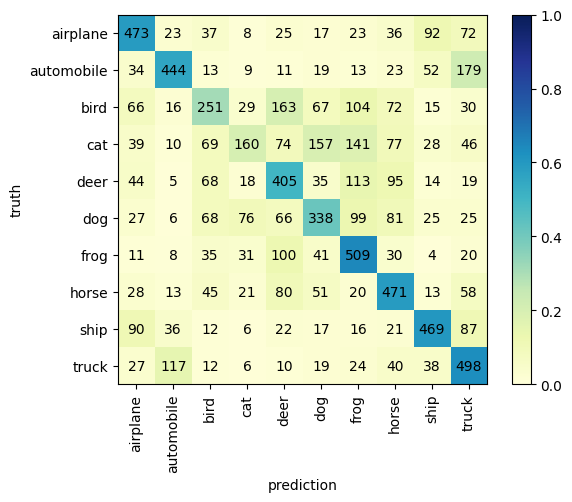

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# Training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history['epoch'], history['loss'], label='Training Loss')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history['epoch'], history['accuracy'], label='Training Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate predictions for the test set
y_predict = model.predict(x_test_normalized, batch_size=128)

# Convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)[:8000]  # Use only the first 8000 labels
y_test_cl = np.argmax(y_test_onehot, axis=1)

# For some reason they had different lengths
# print(f' len(y_predict_cl) = {len(y_predict_cl)}\n len(y_test_cl) = {len(y_test_cl)}')


# Plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)


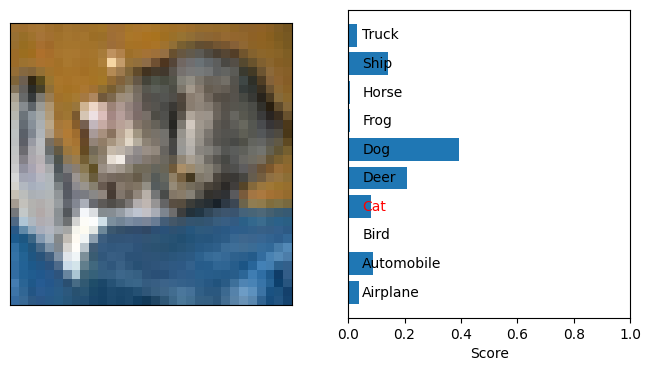

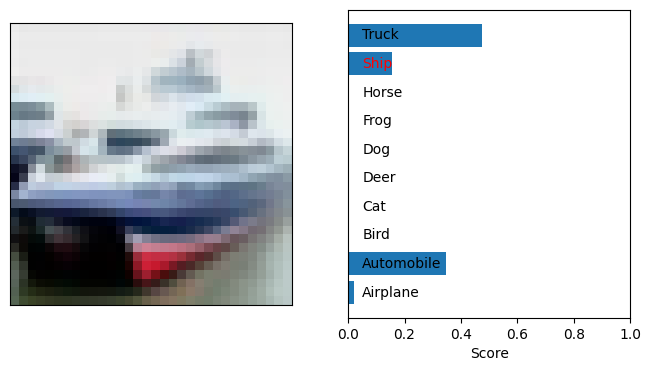

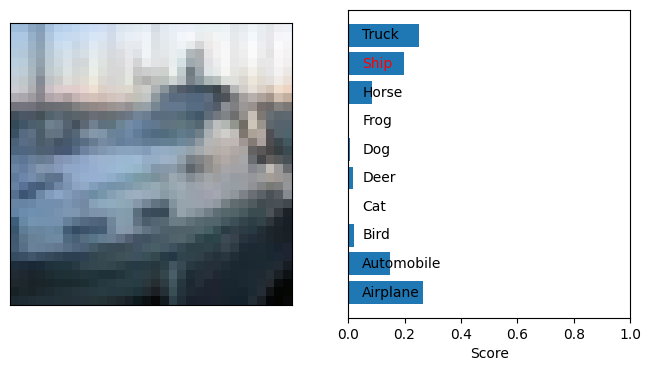

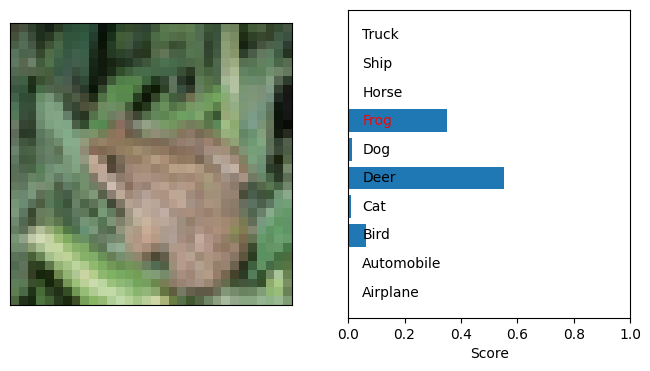

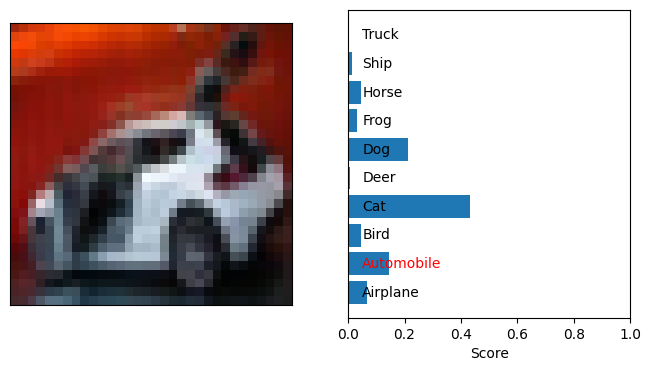

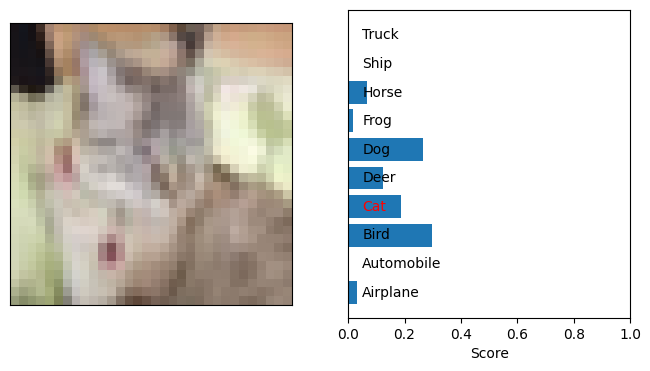

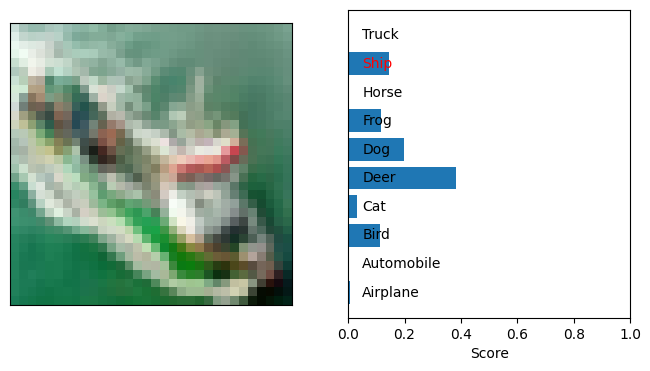

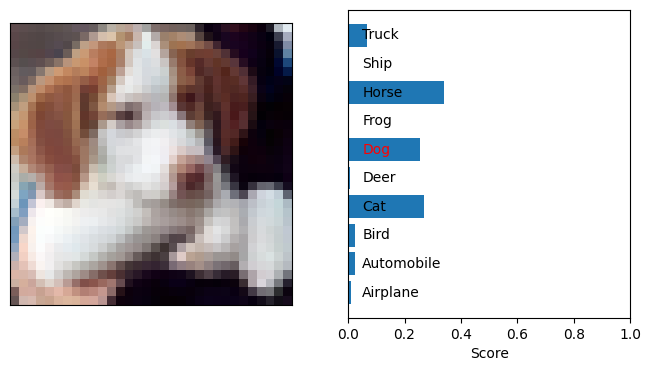

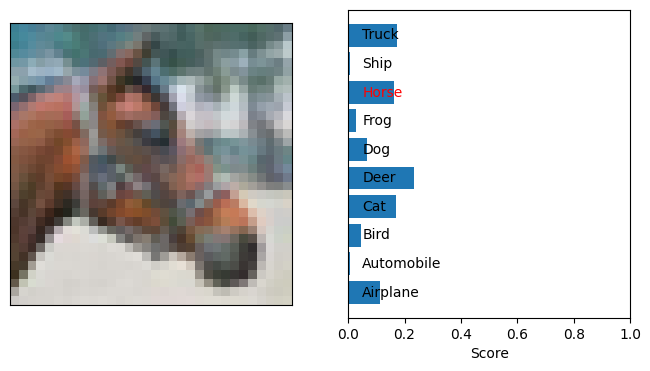

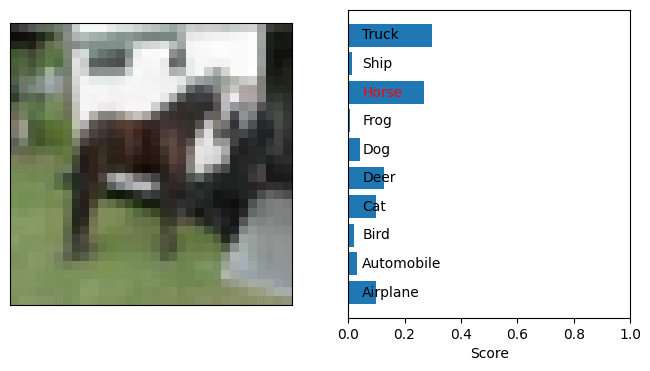

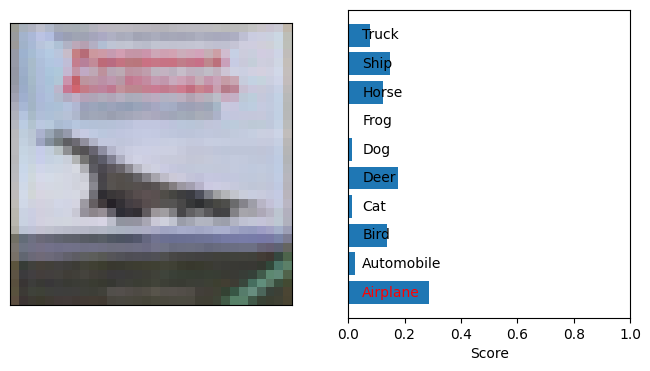

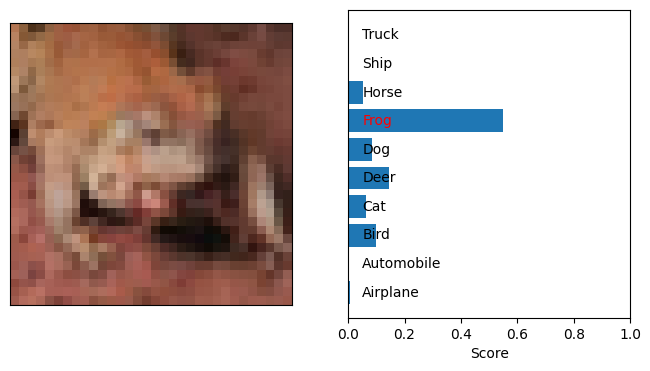

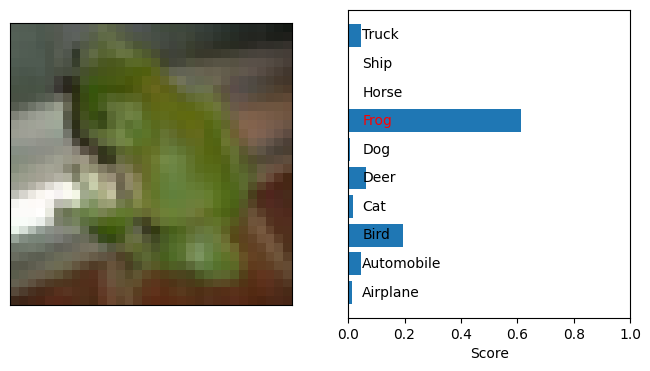

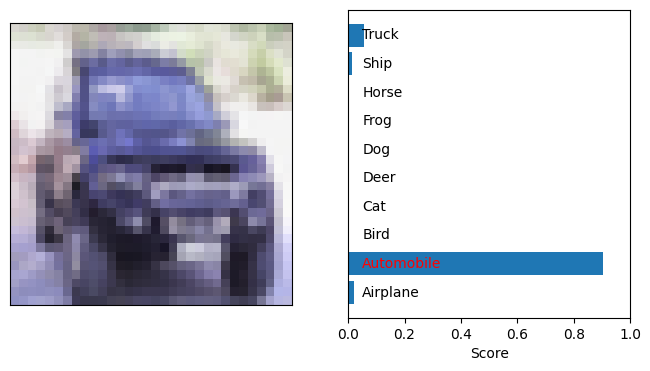

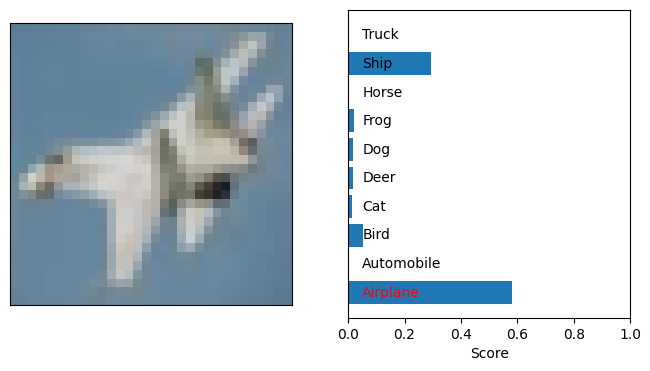

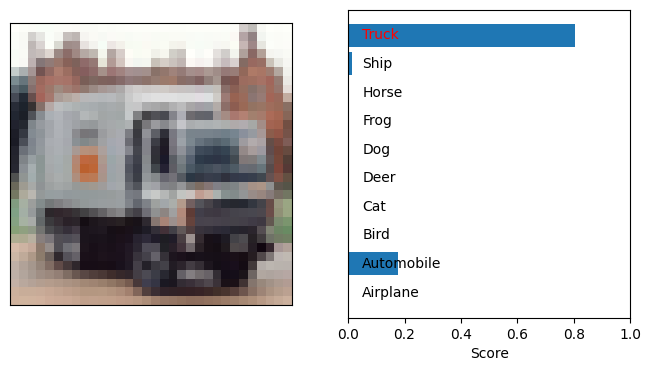

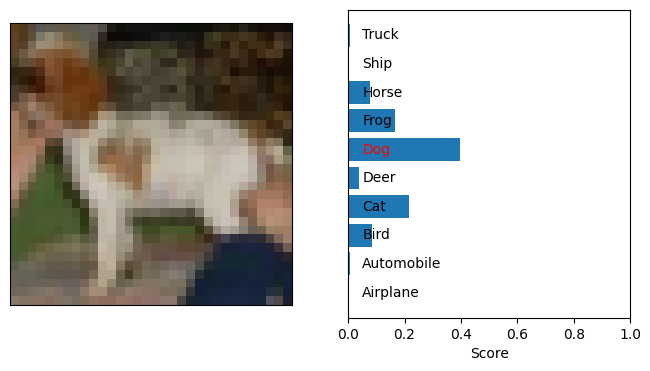

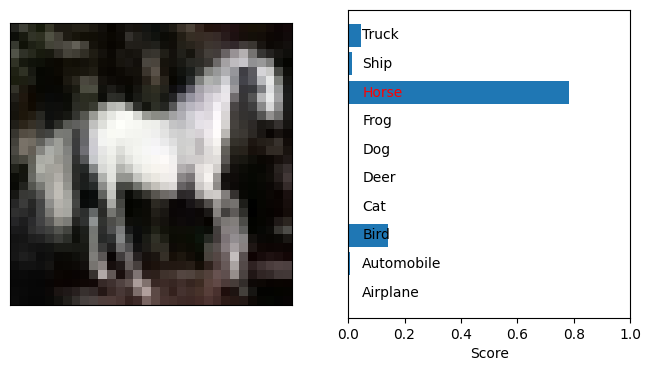

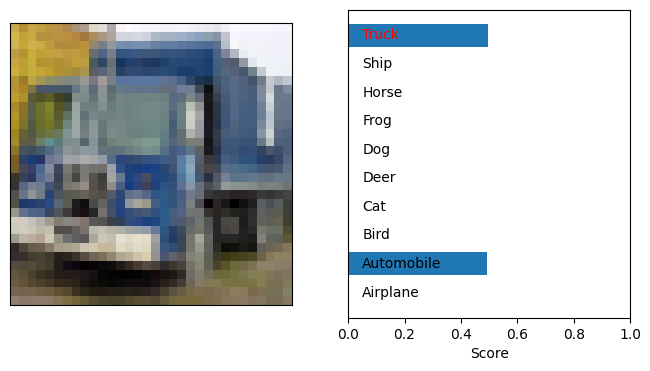

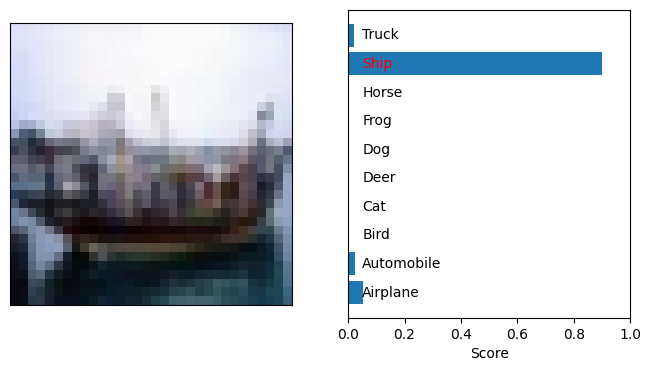

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]   # correctly classified images

# original (unnormalized) test images
x_test_unnormalized = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# Plot first 10 false classifications
for i in i0[:10]:
    plot_prediction(x_test_unnormalized[i], y_test_onehot[i], y_predict[i])

# Plot first 10 correct classifications
for i in i1[:10]:
    plot_prediction(x_test_unnormalized[i], y_test_onehot[i], y_predict[i])

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [ ]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        ... # add additional convolution layer and max pooling layer here,
        layers.Flatten(),
        ... # add dropout and output layer
    ],
    name="cnn",
)

print(model.summary())

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
...
)

model.fit(
    ...
    batch_size=..,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Sorry, I didn't have time to finish all problems